In [ ]:
bucket = 's3://pakplants/'
data_key = ''
data_location = 's3://{}/{}'.format(bucket,data_key)

In [ ]:
#  Check bucket size
!aws s3 ls s3://pakplants/ --recursive --human-readable --summarize

In [ ]:
# import dataset from s3 bucket
import boto3 
import os
from botocore.exceptions import ClientError # Not necessary


s3 = boto3.resource('s3', region_name='ap-south-1') 

bucket = s3.Bucket('pakplants')
for my_bucket_object in bucket.objects.all():    
    key = my_bucket_object.key    
    print(key)    
    if not os.path.exists(os.path.dirname(key)):           
        os.makedirs(os.path.dirname(key))
   
    try:         
        bucket.download_file(key, key)     
    except ClientError as e:         
        if e.response['Error']['Code'] == "404":             
            print("No object with this key.")        
        else:             
            raise

In [ ]:
!pip install PrettyTable
!pip install -q split-folders

## Importing required modules

In [ ]:
import pandas as pd
import numpy as np
import keras
import os
import matplotlib.pyplot as plt
from keras.preprocessing import image
import random
import pickle
from keras import models, layers, callbacks
import shutil
import cv2
from math import sqrt, floor
from prettytable import PrettyTable
from sklearn.metrics import precision_score, accuracy_score, recall_score, confusion_matrix, ConfusionMatrixDisplay

## Exploratory Data Analysis

In [ ]:
dataset = "Pakplantsdata"

classes = os.listdir(dataset)
print("List of categories = ",classes,"\n\nNo. of categories = ", len(classes))

In [ ]:
# Count total number of images in each directory
path='Pakplantsdata'
plt.figure(figsize=(70,70))
count=0
plant_names=[]
total_images=0
for i in os.listdir(path):
  count+=1
  plant_names.append(i)
  plt.subplot(7,7,count)

  images_path=os.listdir(path+"/"+i)
  print("Number of images of "+i+":",len(images_path),end="\n")
  total_images+=len(images_path)

  image_show=plt.imread(path+"/"+i+"/"+images_path[0])
  
  plt.imshow(image_show)
  plt.xlabel(i)
  
  plt.xticks([])
  plt.yticks([])


print("Total number of images we have",total_images)

In [ ]:
filepaths = list(glob.glob(file_path+'/**/*.*'))

In [ ]:
labels = list(map(lambda x: os.path.split(os.path.split(x)[0])[1], filepaths))
filepath = pd.Series(filepaths, name='Filepath').astype(str)
labels = pd.Series(labels, name='Label')
data = pd.concat([filepath, labels], axis=1)
data = data.sample(frac=1).reset_index(drop=True)
data.head(5)

In [ ]:
counts = data.Label.value_counts()
sns.barplot(x=counts.index, y=counts)
plt.xlabel('Type')
plt.xticks(rotation=90);

In [ ]:
fig, axes = plt.subplots(nrows=5, ncols=3, figsize=(10,8), subplot_kw={'xticks':[],'yticks':[]})
for i, ax in enumerate(axes.flat):
    ax.imshow(plt.imread(data.Filepath[i]))
    ax.set_title(data.Label[i])
plt.tight_layout()
plt.show()

In [ ]:
!rm -r output/train/.ipynb_checkpoints
!rm -r output/test/.ipynb_checkpoints
!rm -r output/val/.ipynb_checkpoints
!rm -r Pakplantsdata/.ipynb_checkpoints

## Split the Dataset folder

In [ ]:
import splitfolders 
splitfolders.ratio("Pakplantsdata", output="output", seed=100, ratio=(.8, .1, .1), group_prefix=None) 

In [ ]:
classes= []
sample_counts= []

for f in os.listdir('output/train'):
    train_class_path= os.path.join('output/train', f)
    if os.path.isdir(train_class_path):
        classes.append(f)
        sample_counts.append(len(os.listdir(train_class_path)))

plt.rcdefaults()
fig, ax = plt.subplots()

# Example data
y_pos = np.arange(len(classes))

ax.barh(y_pos, sample_counts, align='center')
ax.set_yticks(y_pos)
ax.set_yticklabels(classes)
ax.invert_yaxis()  # labels read top-to-bottom
ax.set_xlabel('Sample Counts')
ax.set_title('Sample Counts Per Class')

plt.show()

In [ ]:
fig= plt.figure(figsize= (10, 15))
fig.suptitle('Random Samples From Each Class', fontsize=14, y=.92, horizontalalignment='center', weight='bold')

columns = 5
rows = 12
for i in range(12):
    sample_class= os.path.join('output/train',classes[i])
    for j in range(1,6):
        fig.add_subplot(rows, columns, i*5+j)
        plt.axis('off')
        if j==1:
            plt.text(0.0, 0.5,str(classes[i]).replace(' ','\n'), fontsize=13, wrap=True)
            continue
        random_image= os.path.join(sample_class, random.choice(os.listdir(sample_class)))
        #from keras.preprocessing.image
        img = image.load_img(random_image, target_size=(150, 150))
        img= image.img_to_array(img)
        img/=255.
        plt.imshow(img)
        
        

plt.show()

In [ ]:
sample_counts= {}

for i, d in enumerate(['output/train', 'output/val']):

    classes= []
    sample_counts[d]= []

    for f in os.listdir(d):
        train_class_path= os.path.join(d, f)
        if os.path.isdir(train_class_path):
            classes.append(f)
            sample_counts[d].append(len(os.listdir(train_class_path)))

    #fig, ax= plt.subplot(221+i)
    fig, ax = plt.subplots()

    # Example data
    y_pos = np.arange(len(classes))

    ax.barh(y_pos, sample_counts[d], align='center')
    ax.set_yticks(y_pos)
    ax.set_yticklabels(classes)
    ax.invert_yaxis()  # labels read top-to-bottom
    ax.set_xlabel('Sample Counts')
    ax.set_title('{} Sample Counts Per Class'.format(d.capitalize()))

plt.show()

In [ ]:
def pull_random_pixels(samples_per_class, pixels_per_sample):
    total_pixels= 12*samples_per_class*pixels_per_sample
    random_pixels= np.zeros((total_pixels, 3), dtype=np.uint8)
    for i in range(12):
        sample_class= os.path.join('output/train',classes[i])
        for j in range(samples_per_class):
            
            random_image= os.path.join(sample_class, random.choice(os.listdir(sample_class)))
            img= cv2.imread(random_image)
            img= cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
            img=np.reshape(img, (img.shape[0]*img.shape[1], 3))
            new_pixels= img[np.random.randint(0, img.shape[0], pixels_per_sample)]
            
            start_index=pixels_per_sample*(i*samples_per_class+j)
            random_pixels[start_index:start_index+pixels_per_sample,:]= new_pixels

    h= floor(sqrt(total_pixels))
    w= total_pixels//h
    
    random_pixels= random_pixels[np.random.choice(total_pixels, h*w, replace=False)]
    random_pixels= np.reshape(random_pixels, (h, w, 3))
    return random_pixels
    
random_pixels= pull_random_pixels(10, 50)

plt.figure()
plt.suptitle('Random Samples From Each Class', fontsize=14, horizontalalignment='center')
plt.imshow(random_pixels)
plt.show()

In [ ]:
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import cm
from matplotlib import colors

r, g, b = cv2.split(random_pixels)
fig = plt.figure(figsize=(8, 8))
axis = fig.add_subplot(1, 1, 1, projection="3d")
axis.view_init(20, 120)

pixel_colors = random_pixels.reshape((np.shape(random_pixels)[0]*np.shape(random_pixels)[1], 3))
norm = colors.Normalize(vmin=-1.,vmax=1.)
norm.autoscale(pixel_colors)
pixel_colors = norm(pixel_colors).tolist()


axis.scatter(r.flatten(), g.flatten(), b.flatten(), facecolors=pixel_colors, marker=".")
axis.set_xlabel("Red")
axis.set_ylabel("Green")
axis.set_zlabel("Blue")
plt.show()

In [ ]:
hsv_img = cv2.cvtColor(np.uint8(random_pixels), cv2.COLOR_RGB2HSV)

h, s, v = cv2.split(hsv_img)
fig = plt.figure(figsize=(8,8))
axis = fig.add_subplot(1, 1, 1, projection="3d")
axis.view_init(50, 240)



axis.scatter(h.flatten(), s.flatten(), v.flatten(), facecolors=pixel_colors, marker=".")
axis.set_xlabel("Hue")
axis.set_ylabel("Saturation")
axis.set_zlabel("Value")
plt.show()

In [ ]:
hsv_img = cv2.cvtColor(np.uint8(random_pixels), cv2.COLOR_RGB2HSV)

h, s, v = cv2.split(hsv_img)
fig = plt.figure(figsize=(6,6))
axis = fig.add_subplot(1, 1, 1)

axis.scatter(h.flatten(), s.flatten(), facecolors=pixel_colors, marker=".")
axis.set_xlabel("Hue")
axis.set_ylabel("Saturation")
plt.show()

In [ ]:
lower_bound= (24, 50, 0)
upper_bound= (55, 255, 255)

fig= plt.figure(figsize=(10, 10))
fig.suptitle('Random Pre-Processed Image From Each Class', fontsize=14, y=.92, horizontalalignment='center', weight='bold')

for i in range(12):
    sample_class=os.path.join('output/train',classes[i])
    random_image= os.path.join(sample_class, random.choice(os.listdir(sample_class)))
    img= cv2.imread(random_image)
    img= cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    img= cv2.resize(img, (150, 150))
    
    hsv_img= cv2.cvtColor(img, cv2.COLOR_RGB2HSV)
    mask = cv2.inRange(hsv_img, lower_bound, upper_bound)
    result = cv2.bitwise_and(img, img, mask=mask)

    fig.add_subplot(6, 4, i*2+1)
    plt.imshow(img)
    plt.axis('off')    

    fig.add_subplot(6, 4, i*2+2)
    plt.imshow(result)
    plt.axis('off')
    
plt.show()

## Preprocessing

In [ ]:
def color_segment_function(img_array):
    img_array= np.rint(img_array)
    img_array= img_array.astype('uint8')
    hsv_img= cv2.cvtColor(img_array, cv2.COLOR_RGB2HSV)
    mask = cv2.inRange(hsv_img, (24, 50, 0), (55, 255, 255))
    result = cv2.bitwise_and(img_array, img_array, mask=mask)
    result= result.astype('float64')
    return result

In [ ]:
#image function from keras.preprocessing
train_datagen = image.ImageDataGenerator(
      rescale=1./255,
      rotation_range=40,
      width_shift_range=0.0,
      height_shift_range=0.0,
      shear_range=0.0,
      zoom_range=0.0,
      horizontal_flip=True,
      vertical_flip= True,
    preprocessing_function=color_segment_function,  # function 
      fill_mode='nearest')

test_datagen = image.ImageDataGenerator(rescale=1./255, preprocessing_function=color_segment_function)

In [ ]:
train_generator = train_datagen.flow_from_directory(
  'output/train',
  target_size=(224, 224),
  batch_size=20,
  class_mode='categorical')

validation_generator = test_datagen.flow_from_directory(
        'output/val',
        target_size=(224, 224),
        batch_size=20,
        class_mode='categorical')

test_generator = test_datagen.flow_from_directory(
        'output/test',
        target_size=(224,224),
        batch_size=1,
        class_mode='categorical',
        shuffle=False)

In [ ]:
#get class indices and labels. calculate class weight
label_map = {}
for k, v in train_generator.class_indices.items():
    label_map[v]=k

class_counts= pd.Series(train_generator.classes).value_counts()
class_weight= {}

for i, c in class_counts.items():
    class_weight[i]= 1.0/c
    
norm_factor= np.mean(list(class_weight.values()))

for k in class_counts.keys():
    class_weight[k]= class_weight[k]/norm_factor

t = PrettyTable(['class_index', 'class_label', 'class_weight'])
for i in sorted(class_weight.keys()):
    t.add_row([i, label_map[i], '{:.2f}'.format(class_weight[i])])
print(t)

## Model

In [ ]:
model = models.Sequential()

model.add(layers.Conv2D(32, (3, 3), input_shape=(224, 224, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Dropout(0.1))


model.add(layers.Conv2D(64, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Dropout(0.1))



model.add(layers.Conv2D(128, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Dropout(0.1))


model.add(layers.Conv2D(128, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Dropout(0.1))


model.add(layers.Flatten())
model.add(layers.Dropout(0.4))
model.add(layers.Dense(256, activation='relu'))
model.add(layers.Dropout(0.4))

model.add(layers.Dense(26, activation='softmax'))
model.summary()

In [ ]:
best_cb= callbacks.ModelCheckpoint('CNN_model_handled.h5', 
                                         monitor='val_loss', 
                                         verbose=1, 
                                         save_best_only=True, 
                                         save_weights_only=False, 
                                         mode='auto', 
                                         period=1)

opt= keras.optimizers.Adam(lr=0.0005, amsgrad=True)

In [ ]:
model.compile(optimizer=opt,
                loss='categorical_crossentropy',
                metrics=['accuracy'])

history = model.fit_generator(
                    train_generator,
                    class_weight= class_weight,   # providing class weights
                    steps_per_epoch= 150,
                    epochs=25,
                    validation_data=validation_generator,
                    validation_steps= 48,
                    verbose=1,
                    use_multiprocessing=True,
                    callbacks= [best_cb])

modr

In [ ]:
#load best model from training
model_load= models.load_model('CNN_model_handled.h5')

In [ ]:
scores = model.evaluate(test_ds)
scores

In [ ]:
#save history
with open('CNN_model_weight_history.pkl', 'wb') as f:
    pickle.dump(history, f)


In [ ]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_accuracy']
epochs = range(1, len(acc) + 1)
plt.figure()
plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()
plt.figure()
plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()
plt.show()

In [ ]:
plt.figure(figsize=(12, 8))
plt.subplot(1, 2, 1)
plt.plot(range(25), history.history['accuracy'], label='Training Accuracy')
plt.plot(range(25), history.history['val_accuracy'], label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(range(25), loss, label='Training Loss')
plt.plot(range(25), val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

## Model Evaluation

In [ ]:
print(history.history['accuracy'])

In [ ]:
pred= model.predict_generator(test_generator, steps= test_generator.n, verbose=1)

In [ ]:
print("Train Accuracy  : {:.2f} %".format(history.history['accuracy'][-1]*100))\

In [ ]:
predicted_class_indices=np.argmax(pred,axis=1)

prediction_labels = [label_map[k] for k in predicted_class_indices]
filenames= test_generator.filenames

In [ ]:
import numpy as np
from keras.preprocessing import image
import keras


#model = tf.keras.models.load_model('CNN_model_weights.h5')
# predicting images
img = image.load_img("test/Apple.JPG", target_size=(224, 224))


x = image.img_to_array(img)
x = np.expand_dims(x, axis=0)
images = np.vstack([x])
classes = model.predict_classes(images, batch_size=32)
prob = model.predict_proba(images, batch_size= 32)
prob

# CNN-Data Augmentation(ImageGenerator)

In [1]:
from keras.utils import np_utils
from keras.models import Sequential
from keras.layers import Convolution2D,Dense,MaxPool2D,Activation,Dropout,Flatten
from keras.layers import GlobalAveragePooling2D
from keras.optimizers import Adam
from sklearn.model_selection import train_test_split
from keras.layers.normalization import BatchNormalization
import os 
import pandas as pd
import plotly.graph_objs as go
import matplotlib.ticker as ticker
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import cv2
import numpy as np
from sklearn.model_selection import train_test_split
from keras.layers import Input, Add, Dense, Activation, ZeroPadding2D, BatchNormalization, Flatten, Conv2D, AveragePooling2D, MaxPooling2D, GlobalMaxPooling2D

Using TensorFlow backend.


In [2]:
import glob
def get_files(directory):
  if not os.path.exists(directory):
    return 0
  count=0
  for current_path,dirs,files in os.walk(directory):
    for dr in dirs:
      count+= len(glob.glob(os.path.join(current_path,dr+"/*")))
  return count
train_dir ="output/train"
test_dir="output/test"

In [5]:
train_samples =get_files(train_dir)
num_classes=len(glob.glob(train_dir+"/*"))
test_samples=get_files(test_dir)
print(num_classes,"Classes")
print(train_samples,"Train images")
print(test_samples,"Test images")

26 Classes
16192 Train images
2062 Test images


In [3]:
from keras.preprocessing.image import ImageDataGenerator
train_datagen=ImageDataGenerator(rescale=1./255,
                                   shear_range=0.2,
                                   zoom_range=0.2,
                                   horizontal_flip=True)
test_datagen=ImageDataGenerator(rescale=1./255)
img_width,img_height =224,224
input_shape=(img_width,img_height,3)
batch_size =32
train_generator =train_datagen.flow_from_directory(train_dir,
                                target_size=(img_width,img_height),batch_size=batch_size)
test_generator=test_datagen.flow_from_directory(test_dir,shuffle=True,target_size=(img_width,img_height),batch_size=batch_size)

Found 16192 images belonging to 26 classes.
Found 2062 images belonging to 26 classes.


In [6]:
model = Sequential()
model.add(Conv2D(32, (5, 5),input_shape=input_shape,activation='relu',name="conv2d_1"))
model.add(MaxPooling2D(pool_size=(3, 3),name="max_pooling2d_1"))
model.add(Conv2D(32, (3, 3),activation='relu',name="conv2d_2"))
model.add(MaxPooling2D(pool_size=(2, 2),name="max_pooling2d_2"))
model.add(Conv2D(64, (3, 3),activation='relu',name="conv2d_3"))
model.add(MaxPooling2D(pool_size=(2, 2),name="max_pooling2d_3"))   
model.add(Flatten(name="flatten_1"))
model.add(Dense(512,activation='relu'))
model.add(Dropout(0.25))
model.add(Dense(128,activation='relu'))          
model.add(Dense(num_classes,activation='softmax'))
model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 220, 220, 32)      2432      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 73, 73, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 71, 71, 32)        9248      
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 35, 35, 32)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 33, 33, 64)        18496     
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 16, 16, 64)        0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 16384)            

In [7]:
from keras.callbacks import ReduceLROnPlateau
validation_generator = train_datagen.flow_from_directory(
                       test_dir, # same directory as training data
                       target_size=(img_height, img_width),
                       batch_size=batch_size)

Found 2062 images belonging to 26 classes.


In [8]:
model.compile(optimizer='adam',
                  loss = 'categorical_crossentropy',
                  metrics=['accuracy'])
history_1 = model.fit(train_generator,                                    
                                  steps_per_epoch=None, 
                                  epochs=15,validation_data=validation_generator,validation_steps=None
                                  ,verbose=1,callbacks=[ReduceLROnPlateau(monitor='val_loss', factor=0.3,patience=3, min_lr=0.000001)],use_multiprocessing=False,
               shuffle=True)

Epoch 1/15
506/506 [==============================] - 1598s 3s/step - loss: 1.2527 - accuracy: 0.5826 - val_loss: 0.6696 - val_accuracy: 0.7604
Epoch 2/15
506/506 [==============================] - 1573s 3s/step - loss: 0.6318 - accuracy: 0.7902 - val_loss: 0.5417 - val_accuracy: 0.8497
Epoch 3/15
506/506 [==============================] - 1489s 3s/step - loss: 0.4548 - accuracy: 0.8492 - val_loss: 0.4693 - val_accuracy: 0.9006
Epoch 4/15
506/506 [==============================] - 1476s 3s/step - loss: 0.3560 - accuracy: 0.8862 - val_loss: 0.0748 - val_accuracy: 0.9239
Epoch 5/15
506/506 [==============================] - 1494s 3s/step - loss: 0.2834 - accuracy: 0.9085 - val_loss: 0.2965 - val_accuracy: 0.9389
Epoch 6/15
506/506 [==============================] - 1559s 3s/step - loss: 0.2518 - accuracy: 0.9181 - val_loss: 0.1120 - val_accuracy: 0.9423
Epoch 7/15
506/506 [==============================] - 1483s 3s/step - loss: 0.2104 - accuracy: 0.9308 - val_loss: 0.0537 - val_accuracy:

In [18]:
from keras.models import load_model
model.save('CNN_model_augmentation')

In [19]:
from tensorflow import keras
model2 = keras.models.load_model('CNN_model_augmentation')

## Model Evaluation

In [11]:
model.evaluate(validation_generator)

65/65 [==============================] - 161s 2s/step


[0.3101254105567932, 0.9660523533821106]

dict_keys(['val_loss', 'val_accuracy', 'loss', 'accuracy', 'lr'])


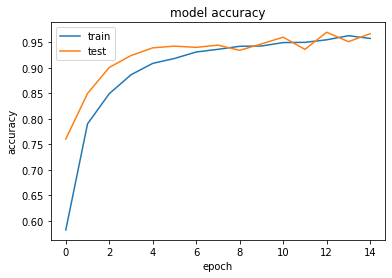

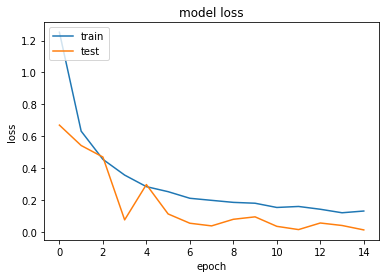

In [12]:
from keras.models import Sequential
from keras.layers import Dense
import matplotlib.pyplot as plt
import numpy

print(history_1.history.keys())

plt.plot(history_1.history['accuracy'])
plt.plot(history_1.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(history_1.history['loss'])
plt.plot(history_1.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

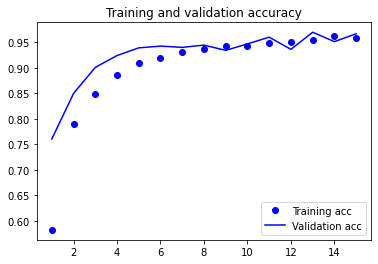

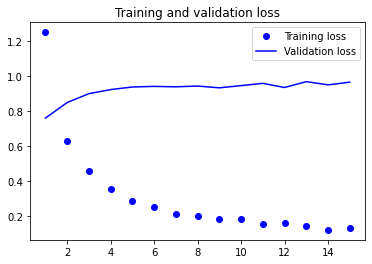

In [28]:
acc = history_1.history['accuracy']
val_acc = history_1.history['val_accuracy']
loss = history_1.history['loss']
val_loss = history_1.history['val_accuracy']
epochs = range(1, len(acc) + 1)
plt.figure()
plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()
plt.figure()
plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()
plt.show()

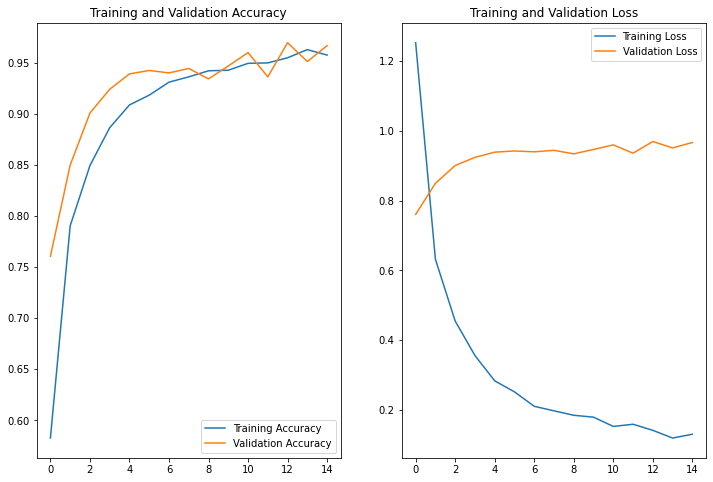

In [33]:
plt.figure(figsize=(12, 8))
plt.subplot(1, 2, 1)
plt.plot(range(15), history_1.history['accuracy'], label='Training Accuracy')
plt.plot(range(15), history_1.history['val_accuracy'], label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(range(15), loss, label='Training Loss')
plt.plot(range(15), val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

In [36]:
print(history_1.history['accuracy'])

[0.5825716, 0.79020506, 0.8491848, 0.8862401, 0.90853506, 0.9181077, 0.93083006, 0.9360178, 0.9419466, 0.9425025, 0.9492342, 0.9496665, 0.954669, 0.9626359, 0.9573246]


[2022-02-27 07:51:25.562 ip-172-16-90-76:3122 INFO utils.py:27] RULE_JOB_STOP_SIGNAL_FILENAME: None
[2022-02-27 07:51:25.699 ip-172-16-90-76:3122 INFO profiler_config_parser.py:111] Unable to find config at /opt/ml/input/config/profilerconfig.json. Profiler is disabled.
[[1.4648227e-08 9.9795890e-01 3.0254802e-07 4.3901582e-05 1.5812233e-10
  2.7941144e-11 1.0995395e-03 2.1491525e-07 8.9232988e-10 1.2673514e-06
  1.9859731e-06 6.3738435e-06 3.9850072e-08 2.3555306e-06 8.0355157e-08
  2.9637645e-10 2.1308298e-07 7.5731879e-07 3.1041029e-05 1.5615807e-07
  3.5056547e-07 3.3834007e-07 1.0778601e-07 2.0848585e-05 2.3734555e-04
  5.9394696e-04]]


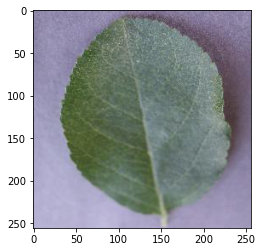

In [37]:
classes=list(train_generator.class_indices.keys())
import numpy as np
import matplotlib.pyplot as plt
# Pre-Processing test data same as train data.
img_width=224
img_height=224
model.compile(optimizer='adam',loss='categorical_crossentropy',metrics=['accuracy'])
from keras.preprocessing import image

def prepare(img_path):
    img = image.load_img(img_path, target_size=(224,224))
    x = image.img_to_array(img)
    x = x/255
    return np.expand_dims(x, axis=0)
    
    
result = model2.predict([prepare('test/Apple.JPG')])

disease=image.load_img('test/Apple.JPG')
plt.imshow(disease)
print(result)

In [38]:
import numpy as np
classresult=np.argmax(result,axis=1)
print(classes[classresult[0]])

Apple


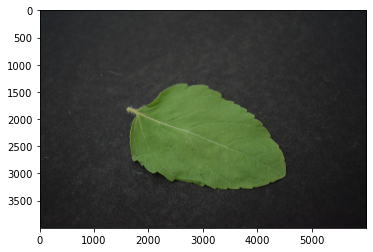

In [25]:
def prepare(img_path):
    img = image.load_img(img_path, target_size=(224,224))
    x = image.img_to_array(img)
    x = x/255
    return np.expand_dims(x, axis=0)
    
    
result = model.predict([prepare('test/Basil.JPG')])

disease=image.load_img('test/Basil.JPG')
plt.imshow(disease)

In [26]:
import numpy as np
classresult=np.argmax(result,axis=1)
print(classes[classresult[0]])

Basil
